In [ ]:
# import os
# import gdal
# import zipfile
# import numexpr
# import datetime
# import requests
# import warnings
# import odc.algo
# import numpy as np
# import pandas as pd
# import xarray as xr
# from collections import Counter
# from scipy.ndimage import binary_dilation

import sys
import datacube    

sys.path.append('../../Scripts')
from dea_datahandling import load_ard
from dea_datahandling import mostcommon_crs
from dea_plotting import animated_timeseries
from dea_coastaltools import tidal_tag
from dea_dask import create_local_dask_cluster

dc = datacube.Datacube(app='Animated timeseries', env='c3-samples')

# Configure local dask cluster
create_local_dask_cluster()
   

from skimage import exposure
from skimage.color import rgb2hsv, hsv2rgb
from skimage.filters import unsharp_mask

def hsv_image_processing(rgb_array,
                         hue_mult=1, sat_mult=1.035, val_mult=1.035,
                         unsharp_radius1=20, unsharp_amount1=2.5, 
                         unsharp_radius2=1, unsharp_amount2=1.0):   
    
    # Convert to HSV and multiply bands
    hsv_array = rgb2hsv(rgb_array)
    hsv_array[:, :, 0] = hsv_array[:, :, 0] * hue_mult
    hsv_array[:, :, 1] = hsv_array[:, :, 1] * sat_mult
    hsv_array[:, :, 2] = hsv_array[:, :, 2] * val_mult
    
    # Apply unsharp mask and take average
    a = unsharp_mask(hsv_array[:, :, 2], radius=unsharp_radius1, amount=unsharp_amount1)
    b = unsharp_mask(hsv_array[:, :, 2], radius=unsharp_radius2, amount=unsharp_amount2)
    hsv_array[:, :, 2] = np.mean(np.array([a, b]), axis=0)
    
    # Convert back to RGB
    return hsv2rgb(hsv_array.clip(0, 1))


# %load_ext autoreload
# %autoreload 2

In [ ]:
from odc.ui import select_on_a_map
    
# Plot interactive map to select area
geopolygon = select_on_a_map(height='600px', 
                             center=(-26, 135), 
                             zoom=4)

In [ ]:


# Obtain native CRS 
crs = mostcommon_crs(dc=dc, 
                     product='ga_ls5t_ard_3', 
                     query={'time': '1990', 
                            'geopolygon': geopolygon})

query = {
    'geopolygon': geopolygon,
    'time': ('1988', '2018'),
    'measurements': ['nbart_red', 'nbart_green', 'nbart_blue'],
    'resampling': {'fmask': 'nearest', 
                   'oa_fmask': 'nearest', 
                   '*': 'average'},
    'output_crs': crs,
    'resolution': (-30, 30),
    'group_by': 'solar_day',
    'dask_chunks': {'time': 1, 'x': 1000, 'y': 1000}
}

ds = load_ard(dc=dc,
              products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'],
              min_gooddata=0.60,
              ls7_slc_off=False,
              mask_contiguity=False,
              mask_pixel_quality=False,
              **query)



In [ ]:
ds = tidal_tag(ds)
ds = ds.sel(time = ds.tide_height < 1)
ds = ds.compute()
ds

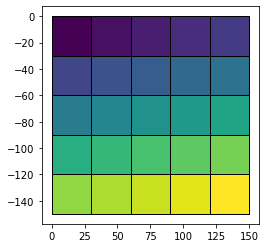

In [6]:
import numpy as np
import geopandas as gpd
import rasterio.features
from shapely.geometry import shape

# Input array to segment and vectorise
input_array = np.random.rand(5, 5)
input_transform = (30, 0, 0, 0, -30, 0)
input_crs = 'EPSG:4326'

# Create array with a unique value per cell
unique_pixels = np.arange(input_array.size).reshape(input_array.shape)

# Vectorise each unique feature in array
vectors = rasterio.features.shapes(source=unique_pixels.astype(np.int16), 
                                     transform=input_transform)

# Convert the generator into a list
vectors = list(vectors)

# Extract the polygon coordinates and values from the list
polygons = [polygon for polygon, value in vectors]
values = [value for polygon, value in vectors]

# Convert polygon coordinates into polygon shapes
polygons = [shape(polygon) for polygon in polygons]

# Create a geopandas dataframe populated with the polygon shapes
gdf = gpd.GeoDataFrame(data={'attribute_col': values},
                       geometry=polygons,
                       crs=input_crs)

# Plot vectors by attribute
gdf.plot(column='attribute_col', edgecolor='black')

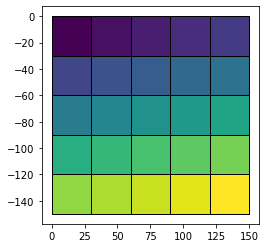

In [7]:
import numpy as np
import geopandas as gpd
import rasterio.features
from shapely.geometry import shape

# Input array to segment and vectorise
input_array = np.random.rand(5, 5)
input_transform = (30, 0, 0, 0, -30, 0)  # replace with xarray transform
input_crs = 'EPSG:4326'  # replace with xarray CRS

# Create array with a unique value per cell
unique_pixels = np.arange(input_array.size).reshape(input_array.shape)

# Vectorise each unique feature in array
vectors = rasterio.features.shapes(source=unique_pixels.astype(np.int16), 
                                     transform=input_transform)

# Extract polygons and values from generator
vectors = list(vectors)
values = [value for polygon, value in vectors]
polygons = [shape(polygon) for polygon, value in vectors]

# Create a geopandas dataframe populated with the polygon shapes
gdf = gpd.GeoDataFrame(data={'id': values},
                       geometry=polygons,
                       crs=input_crs)

# Plot vectors by attribute
gdf.plot(column='id', edgecolor='black')

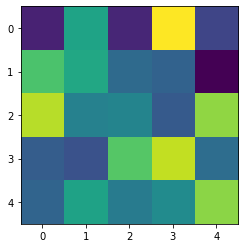

In [9]:

plt.imshow(input_array)

In [ ]:
# Compute rolling median
ds_rolling = ds.rolling(time=19, center=True, min_periods=1).median()

In [ ]:
from functools import partial
image_proc_func = partial(hsv_image_processing, val_mult=1.0, sat_mult=1.3, 
                          unsharp_radius1=75, unsharp_amount1=0.6,
                          unsharp_radius2=4, unsharp_amount2=0.8)


# Produce time series animation of red, green and blue bands
animated_timeseries(ds=ds_rolling ** 0.8, 
                    output_path='animated_timeseries.mp4',  
                    bands=['nbart_red', 'nbart_green', 'nbart_blue'],
                    interval=40, 
                    width_pixels=700,
#                     title='Time-series animation',
                    percentile_stretch=[0.005, 0.99],
                    annotation_kwargs={'fontsize': 20},
                    onebandplot_kwargs={'interpolation': 'nearest'},
                    image_proc_func=image_proc_func) 